In [17]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings('ignore')

import torch 
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset 
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import zlib
import pickle
from matplotlib import pyplot as plt
from scipy.optimize import minimize, basinhopping
from sklearn.datasets import make_circles
from tqdm.notebook import tqdm
import operator
from scipy.special import digamma
from sklearn.neighbors import KDTree, BallTree

import sys 
sys.path.append('/home/bukkacha/Desktop/Inductive bias')
from src.symreg import evaluate_composition, evaluate_tree, SymReg, Node, Composition, get_node_depth, DEFAULT_OPERATIONS
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def contains_pattern(sequence, pattern):
    pattern_str = ''.join(map(str, pattern))
    sequence_str = ''.join(map(str, sequence))
    return pattern_str in sequence_str

In [19]:
y_tasks = []
all_nums = []
for i in range(16):
    all_nums.append(list(map(int, np.binary_repr(i, 4))))
all_nums = np.array(all_nums)
for i in range(8):
    y_tasks.append([])
    pattern = np.binary_repr(i)
    pattern = pattern.rjust(3, '0')
    pattern = list(map(int, list(pattern)))
    if not i in [0, 7]: #i % 2 == 0:
        for y in all_nums:
            y_tasks[-1].append(int(contains_pattern(y, pattern)))
    else:
        for y in all_nums:
            y_tasks[-1].append(int(contains_pattern(y[:3], pattern)) + int(contains_pattern(y[1:], pattern)))
    
all_nums

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

In [20]:
y_tasks = np.array(y_tasks)
y_tasks

array([[2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2]])

In [21]:
rs = np.random.RandomState(42)
new_x, new_y = [], []
for i in range(1, 7):
    
    y_ids = list(range(len(all_nums)))
    while y_tasks[i][y_ids].mean() != 0.5:
        if y_tasks[i][y_ids].mean()>0.5:
            to_add = [j for j in range(len(all_nums)) if y_tasks[i][j] == 0]
        else:
            to_add = [j for j in range(len(all_nums)) if y_tasks[i][j] == 1]
        to_add = rs.choice(to_add)
        y_ids.append(to_add)
    new_x.append(all_nums[y_ids])
    new_y.append(y_tasks[i][y_ids])
    

In [22]:
from collections import Counter
rs = np.random.RandomState(42)
for i in [0, 7]:
    y_ids = list(range(len(all_nums)))
    cnt0 = (y_tasks[i][y_ids]==0).sum()
    cnt1 =  (y_tasks[i][y_ids]==1).sum()
    cnt2 =  (y_tasks[i][y_ids]==2).sum()

    while (cnt0 != cnt1) or (cnt1 != cnt2):
        to_add = np.argsort([cnt0, cnt1, cnt2])[0]
        to_add = [j for j in range(len(all_nums)) if y_tasks[i][j] == to_add]
        to_add = rs.choice(to_add)
        y_ids.append(to_add)
        cnt0 = (y_tasks[i][y_ids]==0).sum()
        cnt1 = (y_tasks[i][y_ids]==1).sum()
        cnt2 = (y_tasks[i][y_ids]==2).sum()


    new_x.append(all_nums[y_ids])
    new_y.append(y_tasks[i][y_ids])
    

In [23]:
new_x

[array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1],
        [0, 0, 1, 1],
        [1, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [1, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]]),
 array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1],
        [0, 1, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 0, 1],
        [0, 1, 0, 1],
        

In [24]:
new_y

[array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2])]

In [ ]:
def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)

def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric='chebyshev')
    return KDTree(points, metric='chebyshev')

def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)

def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))

def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]

def mi(x, y, z=None, k=3, base=2):
    """ Mutual information of x and y (conditioned on z if z is not None)
        x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
        if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x) #add noise to both of x and y
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = avgdigamma(x, dvec), avgdigamma(
            y, dvec), digamma(k), digamma(len(x))
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = avgdigamma(xz, dvec), avgdigamma(
            yz, dvec), avgdigamma(z, dvec), digamma(k)
    return (-a - b + c + d) / np.log(base)

def mymi(x1, x2):
    x1 = np.array(x1)
    x1 = (x1-x1.mean(0))/(1e-10+x1.std(0))
    x2 = np.array(x2)
    x2 = (x2-x2.mean(0))/(1e-10+x2.std(0))
    return mi.mi(x1, x2)

In [ ]:
import heapq
from collections import defaultdict, Counter
from functools import partial
from copy import deepcopy

class Node:
    def __init__(self, value, children=None):
        self.value = value
        self.children = children or []

    def is_leaf(self):
        return len(self.children) == 0

    def __str__(self):
        if self.is_leaf():
            return str(self.value)
        return f"{self.value}(" + ", ".join(map(str, self.children)) + ")"

    def polish(self, ops):
        operations = {}
        alphabet = 'ABCDEFGHIJKLMOQRSTUVWYZ'
        for k in ops:
            operations[k] = alphabet[len(operations)]
        if self.is_leaf():
            if self.value.startswith('p'):
                return 'P'
            else:
                return 'X'
        return f"{operations[self.value]}" + ",".join(
            map(partial(Node.polish, ops=ops), self.children))

    def copy(self):
        return deepcopy(self)

def get_all_polish(children):
    elements = []
    for root in children:
        buf = [root]
        while len(buf)>0:
            element = buf.pop()
            elements.append(element.polish(DEFAULT_OPERATIONS))
            buf.extend(element.children)
    return Counter(elements)
        

def huffman_coding_length(counter):
    heap = [[freq, [sym, ""]] for sym, freq in counter.items()]
    heapq.heapify(heap)

    if len(heap) == 1:
        return list(counter.values())[0]

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = "0" + pair[1]
        for pair in hi[1:]:
            pair[1] = "1" + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    huff_dict = {sym: code for freq, *rest in heap for sym, code in rest}
    total_bits = sum(len(huff_dict[sym]) * freq for sym, freq in counter.items())
    return total_bits

def compute_huffman_compression_score(root):
    counter = get_all_polish(root)
    

    huffman_bits = huffman_coding_length(counter)
    return huffman_bits

x1 = Node('x0')
x2 = Node('x1')
x3 = Node('x2')
x4 = Node('x3')
p0 = Node('p0')
p1 = Node('p1')
p2 = Node('p2')
p3 = Node('p3')
p4 = Node('p4')
p5 = Node('p5')
p6 = Node('p6')
p7 = Node('p7')
p8 = Node('p8')

h10 = Node('mult', [p0, x1])
h11 = Node('mult', [p1, x2])
h12 = Node('mult', [p2, x3])

h20 = Node('mult', [p0, x2])
h21 = Node('mult', [p1, x3])
h22 = Node('mult', [p2, x4])

h1 = Node('add', [p3, Node('add', [h10, Node('add', [h11, h12])])])
h2 = Node('add', [p4, Node('add', [h20, Node('add', [h21, h22])])])

h1_ = Node('h0')
h2_ = Node('h1')

g0_max = Node('max', [h1_, h2_])
g0 = Node('add', [g0_max, p5])



h111 = Node('max', [h1_, p5])

h222 = Node('max', [h2_, p5])
g1 = h222
g1 = Node('add', [h111, h222])
g0 = g0
comp = Composition([h1, h2], [g0, g1])

In [ ]:
get_node_depth(g1)

2

In [32]:
np.equal(evaluate_composition(comp, {f'x{i}':new_x[7][:, i] for i in range(4)}, {'p0':1, 'p1':1, 'p2': 1, 'p3':-2,
                                                                 'p4': -2.0, 'p5': -0.0},
                     DEFAULT_OPERATIONS, g_id=1), new_y[7])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [33]:
print (comp)


h_0 = add(p3, add(mult(p0, x0), add(mult(p1, x1), mult(p2, x2))))
h_1 = add(p4, add(mult(p0, x1), add(mult(p1, x2), mult(p2, x3))))
g_0 = add(max(h0, h1), p5)
g_1 = add(max(h0, p5), max(h1, p5))


In [ ]:
from scipy.optimize import brute, basinhopping, minimize
from functools import partial
from symreg import evaluate_composition, DEFAULT_OPERATIONS

import zlib


def compress_score(expression_str: str):
    compressed = zlib.compress(expression_str.encode('utf-8'))
    return len(compressed)


def compress_hiddens(composition):
    return compress_score(';'.join([
        h.polish(DEFAULT_OPERATIONS) for h in composition.children_h]))

def acc_loss_fn_min(x, y, ind, variables, pool, OPERATIONS):
    bad_val = [9999] * (1 + 2 +8)
    multistart_num = 20
    param_num = len(pool)
    losses = [0.0]
    
    compl = compute_huffman_compression_score(ind.children_h)
    if compl > 62:
        return bad_val
    
    losses.append(compl)
    losses.append(0.0) # MI
    
    losses[0] += losses[-1]
    
    def min_func(x0, var_y, debug = False):
        var_, y_ = var_y
        pool_ = {f'p{i}': x0[i] for i in range(param_num)}
        y_pred = evaluate_composition(ind, var_, pool_, OPERATIONS) > 0
        errs = 1.0-np.equal(y_, y_pred).mean()
        return errs
    
    def min_func2(x0, var_y):
        var_, y_ = var_y
        pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
        y_pred = evaluate_composition(ind, var_, pool_, OPERATIONS, g_id=1)
        y_pred = np.clip(y_pred, 0, 2)
        errs = ((y_ - y_pred)**2).mean() / 2
        return errs
    
    for i in range(6):
        x_train1 = {f'x{j}': new_x[i][:, j] for j in range(4)}
        y_train1 = new_y[i]
        best = None, None
        #print ('--')
        for _ in range(multistart_num):
            x_opt = minimize(partial(min_func, var_y = [x_train1, y_train1]),  np.random.uniform(-3, 3, size=param_num), 
                             options = {'maxiter': 10000},
                             method='Powell', bounds=[(-3.0, 3.0)]*param_num) #,  [(-3, 3)]*param_num, Ns=20)
            if best[1] is None or best[1]>x_opt.fun:
                best = x_opt, x_opt.fun
                #print ('*')
                if best[1] == 0.0:
                    break
        x_opt = best[0]
        losses.append(min_func(x_opt.x, [x_train1, y_train1]))
        losses[0] += losses[-1]
        
        hidden1, out1 = evaluate_composition(ind, x_train1, {f'p{i}': x_opt.x[i] for i in range(param_num)}, 
                                             OPERATIONS, 0, True)
        hidden1_array = []
        for h in hidden1.values():
            h = np.array(h)
            if len(h.shape) == 0:
                h = np.ones(len(y_train1) )* h
                
            hidden1_array.append(h)
        hidden1_array = np.array(hidden1_array).T
        losses[2] += mymi(hidden1_array, np.array(list(x_train1.values())).T)
        
    
    for i in range(6, 8):
        x_train2 = {f'x{j}': new_x[i][:, j] for j in range(4)}
        y_train2 = new_y[i]
        best = None, None
        for _ in range(multistart_num):
            x_opt = minimize(partial(min_func2, var_y = [x_train2, y_train2]),
                             np.random.uniform(-3, 3, size=param_num), 
                             options = {'maxiter': 10000},
                             method='Powell', bounds=[(-3.0, 3.0)]*param_num) #,  [(-3, 3)]*param_num, Ns=20)
            if best[1] is None or best[1]>x_opt.fun:
                best = x_opt, x_opt.fun
                #print ('*')
                if best[1] == 0.0:
                    break
        x_opt = best[0]
        
        losses.append(min_func2(x_opt.x, [x_train2, y_train2]))
        losses[0] += losses[-1]
        
        
        
        hidden1, out1 = evaluate_composition(ind, x_train2, {f'p{i}': x_opt.x[i] for i in range(param_num)}, 
                                             OPERATIONS, 0, True)
        hidden1_array = []
        for h in hidden1.values():
            h = np.array(h)
            if len(h.shape) == 0:
                h = np.ones(len(y_train2) )* h
                
            hidden1_array.append(h)
        hidden1_array = np.array(hidden1_array).T
        losses[2] += mymi(hidden1_array, np.array(list(x_train2.values())).T)
        
    if losses[2] >= 10.2:
        return bad_val
    losses[0] += (losses[1]/62)*0.1
    losses[0] += (losses[2]/10.2)*0.1
    
    
    return tuple(losses)

In [ ]:
import pickle
import operator
reduced_operations = {
    'add': (operator.add, 2),
    'sub': (operator.sub, 2),
    'mult': (operator.mul, 2),
    'max': (np.maximum, 2)
}
np.random.seed(42)
import time
time_s = time.time()
run_num = 5
gens = []
for r in range(run_num):
    symreg = SymReg(acc_loss_fn_min,
                    new_x[0],
                    new_y[0],
                    10,
                    2,
                    2,
                    6,
                    1000,
                    proc_num = 8,
                    operations=reduced_operations,
                    mutate_params=False,
                    max_depth=4)
    gens.append(symreg.fit(50, 10, 10, 10))
    with open('results_exp5.pckl', 'wb') as out:
        out.write(pickle.dumps(gens))

[Gen 0] Expr: 
h_0 = max(x1, p2)
h_1 = x2
g_0 = mult(sub(sub(max(p5, h0), max(p1, p0)), sub(mult(h1, h0), max(h1, h0))), add(max(mult(h1, h1), add(p4, h1)), add(h0, mult(p4, p1))))
g_1 = mult(h0, sub(mult(h1, p3), sub(p0, p1)))
[Gen 0] Best errors: (np.float64(1.908252118743698), 6.0, np.float64(8.482576326910939), np.float64(0.33333333333333337), np.float64(0.16666666666666663), np.float64(0.33333333333333337), np.float64(0.16666666666666663), np.float64(0.16666666666666663), np.float64(0.33333333333333337), np.float64(0.20430107526881716), np.float64(0.11111111111111108))
[Gen 0] Total time: 164.4539704322815


In [15]:
qual = []
for f in gens:
    qual.append(f.fitness.getValues()[1:])
print (np.mean(qual,0), np.min(qual, 0))


[0.175      0.11328329 0.         0.         0.         0.        ] [0.08333333 0.04253008 0.         0.         0.         0.        ]


In [59]:

x_train1 = {f'x{i}':X_all[:24,i] for i in range(4)}
y_train1 = y_all[:24]

def min_func(x0, var_y):
    var_, y_ = var_y
    pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
    y_pred = evaluate_composition(comp, var_, pool_, DEFAULT_OPERATIONS) > 0
    errs = 1.0-np.equal(y_, y_pred).mean()
    
    return errs

x_opt = basinhopping(partial(min_func, var_y = [x_train1, y_train1]),  [-0.0, -0.0])
loss1 = min_func(x_opt.x, [x_train1, y_train1])
loss1

np.float64(0.0)

In [38]:

np.equal(np.round(evaluate_composition(comp, {f'x{i}':X_all[:24,i] for i in range(4)}, {'p0':  -1.0}, DEFAULT_OPERATIONS)) > 0, y_all[:24])


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [48]:
y_all[:24]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
def simple_mi(h, y):
    mi = 0.0
    for _ in range(100):
        P = np.random.randn(h.shape[1], 1)

        cov_matrix = np.cov(h @ P, y.reshape(-1, 1).T, rowvar=False)
        mi += cov_matrix[0, 1]**2
    return mi

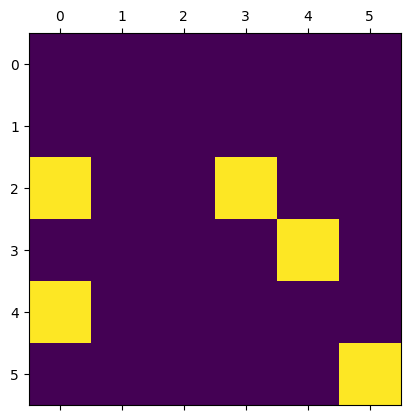

In [ ]:
mat = np.zeros((6, 6))
i = np.unravel_index([12, 15, 22, 24, 35], [6, 6])
mat[i] = 1
plt.matshow(mat)